<a href="https://colab.research.google.com/github/anushree0001/Genetic-Algorithm-Smart-grid-/blob/main/SmartGridUsingGeneticEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
url = "https://raw.githubusercontent.com/anushree0001/Genetic-Algorithm-Smart-grid-/main/smartgrid_dataset_6k.csv"
df = pd.read_csv(url)

df.head()

,Hour,Node,Demand_kWh,Loss_Percentage,Storage_Capacity_kWh,Source,Supply_kWh,Cost_per_kWh
0,1,Node_1,152,7.00,429,Solar,577,0.11
1,1,Node_1,152,7.00,429,Wind,353,0.17
2,1,Node_1,152,7.00,429,Hydro,497,0.17
3,1,Node_10,78,9.74,393,Solar,512,0.11
4,1,Node_10,78,9.74,393,Wind,311,0.17


In [3]:
# Define node labels
node_labels = {
    "Node_1": "Residential Zone A", "Node_2": "Residential Zone B",
    "Node_3": "Industrial Area A", "Node_4": "Industrial Area B",
    "Node_5": "Commercial District A", "Node_6": "Commercial District B",
    "Node_7": "Hospital A", "Node_8": "Hospital B",
    "Node_9": "School Zone A", "Node_10": "School Zone B",
    "Node_11": "University Campus", "Node_12": "Airport Terminal",
    "Node_13": "Railway Station", "Node_14": "Shopping Mall",
    "Node_15": "City Hall", "Node_16": "Police HQ",
    "Node_17": "Fire Department", "Node_18": "Water Treatment Plant",
    "Node_19": "Data Center A", "Node_20": "Data Center B",
    "Node_21": "Park Lighting", "Node_22": "Sports Complex",
    "Node_23": "Stadium", "Node_24": "Tourist Center",
    "Node_25": "Suburban Grid A", "Node_26": "Suburban Grid B",
    "Node_27": "Village Cluster A", "Node_28": "Village Cluster B",
    "Node_29": "Mountain Base Camp", "Node_30": "Remote Telecom Tower"
}
# Add the new column
df["Node_Label"] = df["Node"].map(node_labels)

# Save the new dataset
df.to_csv("smartgrid_dataset_6k_labeled.csv", index=False)

In [4]:
print("Summary statistics:\n", df.describe())
print("\nMissing values:\n", df.isnull().sum())

Summary statistics:
               Hour   Demand_kWh  Loss_Percentage  Storage_Capacity_kWh  \
count  6480.000000  6480.000000      6480.000000           6480.000000   
mean     36.500000   124.572222         6.003667            304.300000   
std      20.784209    44.238260         2.282039            121.654815   
min       1.000000    50.000000         2.180000            119.000000   
25%      18.750000    86.000000         3.810000            197.000000   
50%      36.500000   124.000000         6.150000            278.500000   
75%      54.250000   164.000000         7.760000            429.000000   
max      72.000000   199.000000         9.840000            490.000000   

        Supply_kWh  Cost_per_kWh  
count  6480.000000   6480.000000  
mean    444.263889      0.150000  
std      82.021514      0.028286  
min     302.000000      0.110000  
25%     374.000000      0.110000  
50%     444.000000      0.170000  
75%     515.250000      0.170000  
max     596.000000      0.170000

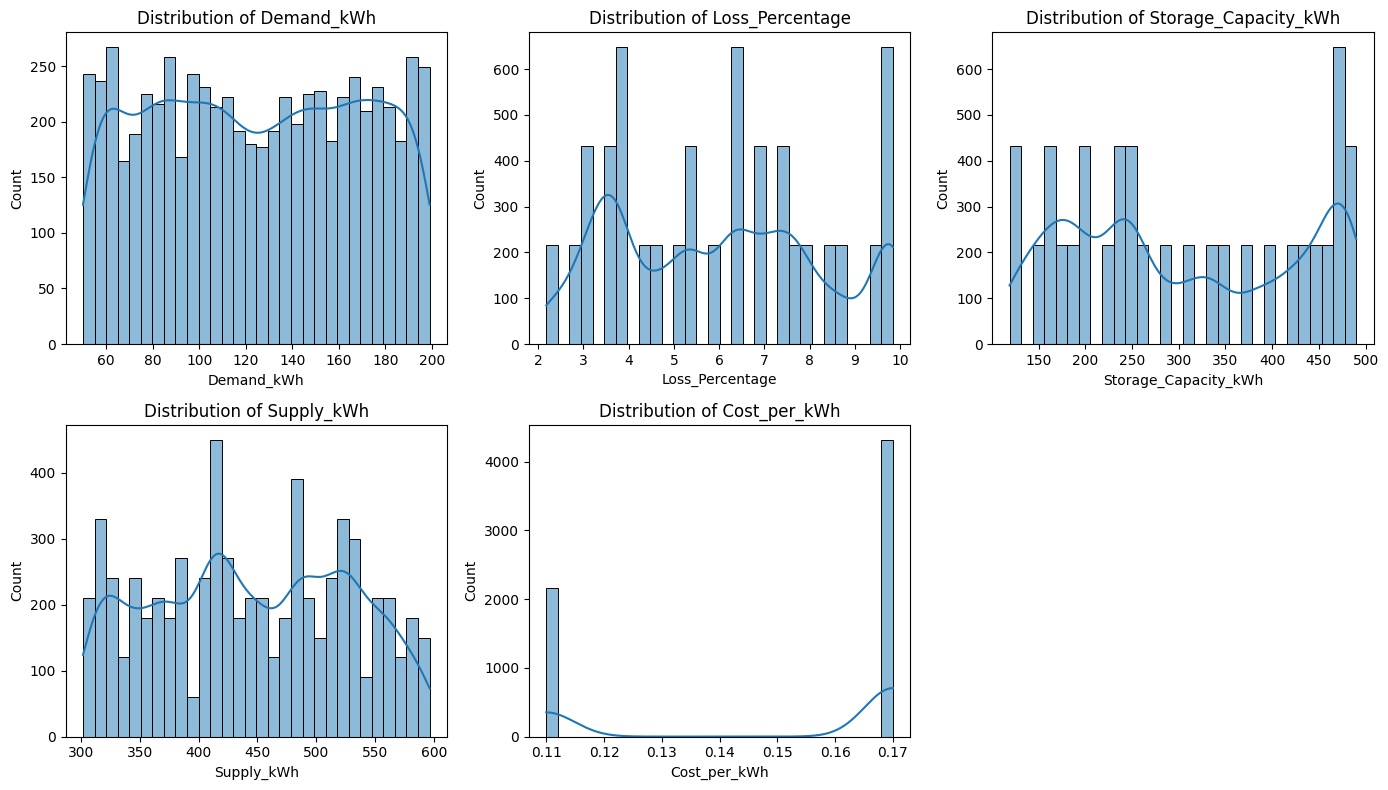

In [5]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(['Demand_kWh', 'Loss_Percentage', 'Storage_Capacity_kWh', 'Supply_kWh', 'Cost_per_kWh']):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()



In [6]:
#  Outlier Detection: IQR Method
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[col] < lower) | (data[col] > upper)], lower, upper

# Detect and remove outliers
outlier_summary = {}
df_clean = df.copy()
for col in ['Demand_kWh', 'Loss_Percentage', 'Storage_Capacity_kWh', 'Supply_kWh', 'Cost_per_kWh']:
    outliers, lb, ub = detect_outliers_iqr(df_clean, col)
    outlier_summary[col] = {'count': len(outliers), 'lower': lb, 'upper': ub}
    df_clean = df_clean[(df_clean[col] >= lb) & (df_clean[col] <= ub)]

In [7]:
print("\nOutlier Summary:")
for k, v in outlier_summary.items():
    print(f"{k}: {v['count']} outliers")


Outlier Summary:
Demand_kWh: 0 outliers
Loss_Percentage: 0 outliers
Storage_Capacity_kWh: 0 outliers
Supply_kWh: 0 outliers
Cost_per_kWh: 0 outliers


In [8]:
# Feature Engineering
df_clean['Net_Supply_kWh'] = df_clean['Supply_kWh'] - df_clean['Demand_kWh']
df_clean['Storage_Utilization_Rate'] = df_clean['Demand_kWh'] / df_clean['Storage_Capacity_kWh']
df_clean['Effective_Cost'] = df_clean['Cost_per_kWh'] * df_clean['Supply_kWh']


In [9]:
#  One-hot encode the Source column if it exists
if 'Source' in df_clean.columns:
    df_clean = pd.get_dummies(df_clean, columns=['Source'], prefix='Source')
else:
    print(" 'Source' column not found, skipping one-hot encoding.")


In [10]:
from sklearn.preprocessing import LabelEncoder
#Encode Node for modeling
le_node = LabelEncoder()
df_clean['Node'] = le_node.fit_transform(df_clean['Node'])

In [11]:
df_clean['Storage_Utilization_Rate'] = df_clean['Demand_kWh'] / df_clean['Storage_Capacity_kWh']


In [12]:
# Prevent division by zero
df_clean['Storage_Utilization_Rate'] = df_clean.apply(
    lambda row: row['Demand_kWh'] / row['Storage_Capacity_kWh'] if row['Storage_Capacity_kWh'] != 0 else 0,
    axis=1
)


In [13]:
# Replace inf/-inf with NaN then drop
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(inplace=True)


In [14]:
from sklearn.preprocessing import MinMaxScaler

# Safe calculation to avoid division by zero
df_clean['Storage_Utilization_Rate'] = df_clean.apply(
    lambda row: row['Demand_kWh'] / row['Storage_Capacity_kWh'] if row['Storage_Capacity_kWh'] != 0 else 0,
    axis=1
)

# Compute other features
df_clean['Net_Supply_kWh'] = df_clean['Supply_kWh'] - df_clean['Demand_kWh']
df_clean['Effective_Cost'] = df_clean['Cost_per_kWh'] * df_clean['Supply_kWh']

# Clean invalid values before scaling
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(inplace=True)

# Now apply scaling
scaler = MinMaxScaler()
num_cols = ['Demand_kWh', 'Loss_Percentage', 'Storage_Capacity_kWh', 'Supply_kWh',
            'Cost_per_kWh', 'Net_Supply_kWh', 'Storage_Utilization_Rate', 'Effective_Cost']
df_clean[num_cols] = scaler.fit_transform(df_clean[num_cols])

In [15]:
# Recalculate features (safe division)
df_clean['Net_Supply_kWh'] = df_clean['Supply_kWh'] - df_clean['Demand_kWh']
df_clean['Storage_Utilization_Rate'] = df_clean.apply(
    lambda row: row['Demand_kWh'] / row['Storage_Capacity_kWh'] if row['Storage_Capacity_kWh'] != 0 else 0,
    axis=1
)
df_clean['Effective_Cost'] = df_clean['Cost_per_kWh'] * df_clean['Supply_kWh']

# Show how many NaN or inf rows exist before dropping
print("NaNs before cleaning:\n", df_clean[num_cols].isna().sum())
print("Infs before cleaning:\n", np.isinf(df_clean[num_cols]).sum())

# Replace inf with NaN and drop only those rows
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(subset=num_cols, inplace=True)

# Confirm the number of remaining rows
print("Remaining rows after cleaning:", df_clean.shape)


NaNs before cleaning:
 Demand_kWh                  0
Loss_Percentage             0
Storage_Capacity_kWh        0
Supply_kWh                  0
Cost_per_kWh                0
Net_Supply_kWh              0
Storage_Utilization_Rate    0
Effective_Cost              0
dtype: int64
Infs before cleaning:
 Demand_kWh                  0
Loss_Percentage             0
Storage_Capacity_kWh        0
Supply_kWh                  0
Cost_per_kWh                0
Net_Supply_kWh              0
Storage_Utilization_Rate    0
Effective_Cost              0
dtype: int64
Remaining rows after cleaning: (6480, 14)


In [16]:
print("Original rows:", df.shape)
print("Rows after outlier filtering:", df_clean.shape)


Original rows: (6480, 9)
Rows after outlier filtering: (6480, 14)


In [17]:
# Re-initialize df_clean
df_clean = df.copy()

# Only apply outlier detection to 2 key columns
critical_cols = ['Demand_kWh', 'Loss_Percentage']

for col in critical_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lb) & (df_clean[col] <= ub)]

print("Rows after safer outlier filtering:", df_clean.shape)


Rows after safer outlier filtering: (6480, 9)


In [18]:
# Feature Engineering
df_clean['Net_Supply_kWh'] = df_clean['Supply_kWh'] - df_clean['Demand_kWh']

df_clean['Storage_Utilization_Rate'] = df_clean.apply(
    lambda row: row['Demand_kWh'] / row['Storage_Capacity_kWh']
    if row['Storage_Capacity_kWh'] != 0 else 0,
    axis=1
)

df_clean['Effective_Cost'] = df_clean['Cost_per_kWh'] * df_clean['Supply_kWh']

# One-hot encode 'Source' (only if it exists)
if 'Source' in df_clean.columns:
    df_clean = pd.get_dummies(df_clean, columns=['Source'], prefix='Source')

# Encode 'Node'
le_node = LabelEncoder()
df_clean['Node'] = le_node.fit_transform(df_clean['Node'])

# Scale numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_cols = ['Demand_kWh', 'Loss_Percentage', 'Storage_Capacity_kWh', 'Supply_kWh',
            'Cost_per_kWh', 'Net_Supply_kWh', 'Storage_Utilization_Rate', 'Effective_Cost']
df_clean[num_cols] = scaler.fit_transform(df_clean[num_cols])



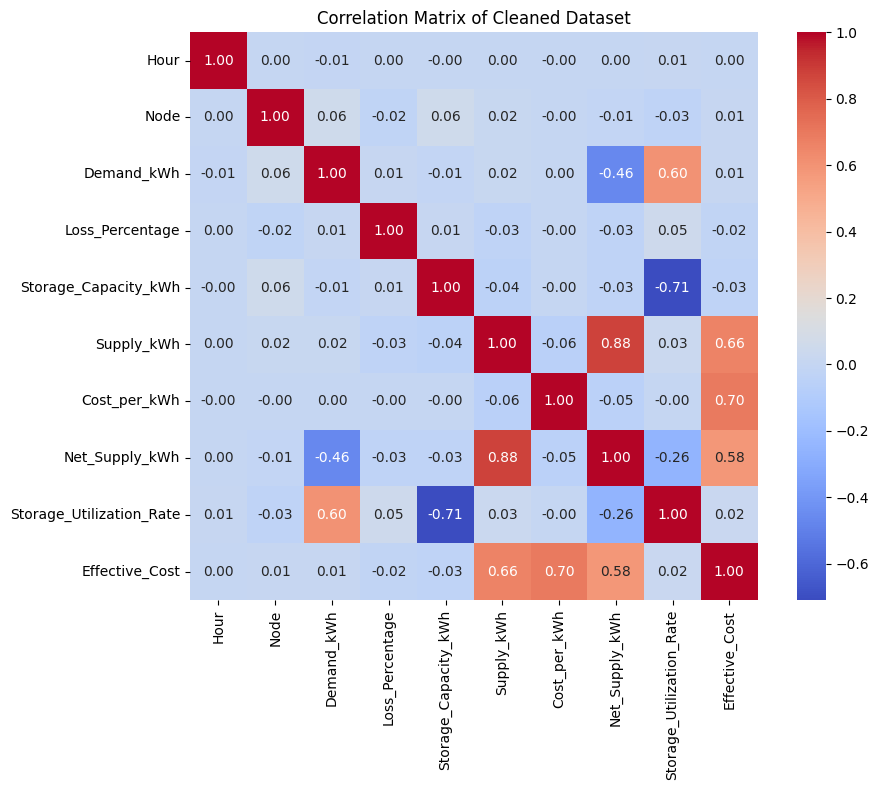

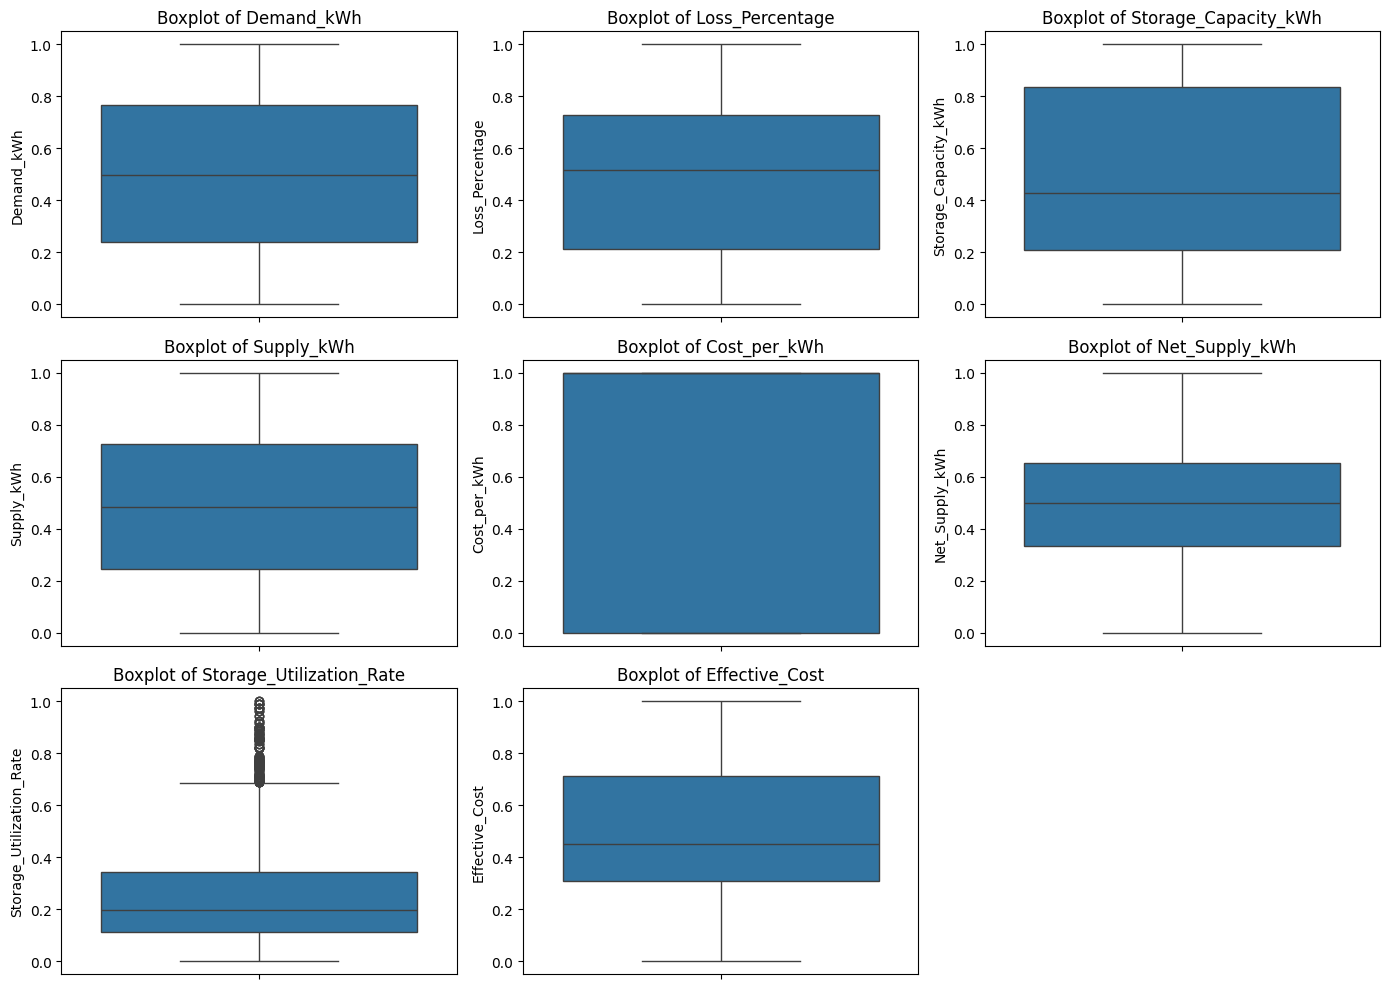

,Hour,Node,Demand_kWh,Loss_Percentage,Storage_Capacity_kWh,Supply_kWh,Cost_per_kWh,Net_Supply_kWh,Storage_Utilization_Rate,Effective_Cost
count,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000
mean,36.500000,14.500000,0.500485,0.499173,0.499461,0.483891,0.666667,0.492481,0.247538,0.488769
std,20.784209,8.656109,0.296901,0.297916,0.327911,0.278985,0.471441,0.210378,0.185959,0.251787
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.750000,7.000000,0.241611,0.212794,0.210243,0.244898,0.000000,0.331818,0.110630,0.308517
50%,36.500000,14.500000,0.496644,0.518277,0.429919,0.482993,1.000000,0.497727,0.197107,0.450661
75%,54.250000,22.000000,0.765101,0.728460,0.835580,0.725340,1.000000,0.652273,0.341115,0.713546
max,72.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#  EDA on Cleaned Data
# Summary statistics
clean_summary_stats = df_clean.describe()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Cleaned Dataset")
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df_clean, y=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Show numeric summary
clean_summary_stats

In [20]:
import numpy as np

# Define nodes, sources, hours
nodes = ['Node_1', 'Node_2', 'Node_3']
sources = ['Solar', 'Wind']
hours = [1, 2]

# Demand per node per hour
demand = {
    ('Node_1', 1): 50, ('Node_1', 2): 60,
    ('Node_2', 1): 40, ('Node_2', 2): 30,
    ('Node_3', 1): 30, ('Node_3', 2): 20,
}

# Supply available per source per hour
supply = {
    ('Solar', 1): 100, ('Solar', 2): 90,
    ('Wind', 1): 80, ('Wind', 2): 70,
}

# Cost and loss %
cost_per_kwh = {'Solar': 0.11, 'Wind': 0.17}
loss_percentage = {'Solar': 0.05, 'Wind': 0.10}
chromosome_shape = (len(nodes), len(sources), len(hours))



In [21]:
# --- GA Components ---
def random_chromosome():
    return np.random.uniform(low=0, high=30, size=chromosome_shape)

def greedy_chromosome():
    chrom = np.zeros(chromosome_shape)
    for i, node in enumerate(nodes):
        for h_idx, hr in enumerate(hours):
            remaining = demand[(node, hr)]
            for j, src in sorted(enumerate(sources), key=lambda x: cost_per_kwh[x[1]]):
                alloc = min(remaining, supply[(src, hr)])
                chrom[i, j, h_idx] = alloc
                remaining -= alloc
                if remaining <= 0:
                    break
    return chrom

In [22]:
def adaptive_mutation_rate(gen, max_gen):
    return 0.2 * (1 - gen / max_gen)

def fitness(chromosome):
    penalty, total_cost, total_loss = 0, 0, 0
    allocation = chromosome.reshape(len(nodes), len(sources), len(hours))
    supply_used = {(src, hr): 0 for src in sources for hr in hours}

    for i, node in enumerate(nodes):
        for h_idx, hr in enumerate(hours):
            demand_required = demand[(node, hr)]
            total_allocated = 0
            for j, src in enumerate(sources):
                alloc = allocation[i, j, h_idx]
                loss = alloc * loss_percentage[src]
                net = alloc - loss
                total_allocated += net
                supply_used[(src, hr)] += alloc
                total_cost += alloc * cost_per_kwh[src]
                total_loss += loss
            if total_allocated < demand_required:
                penalty += (demand_required - total_allocated) ** 2
    for key, used in supply_used.items():
        if used > supply[key]:
            penalty += (used - supply[key]) ** 2
    return -(1.0 * total_cost + 5.0 * total_loss + 10.0 * penalty)


In [23]:

def select(population, fitnesses, k):
    idx = np.argsort(fitnesses)[-k:]
    return [population[i] for i in idx]

def crossover(p1, p2, crossover_rate=0.5):
    mask = np.random.rand(*p1.shape) < crossover_rate
    return np.where(mask, p1, p2)

def mutate(chromosome, mutation_rate):
    mutation = np.random.uniform(-5, 5, size=chromosome.shape)
    mask = np.random.rand(*chromosome.shape) < mutation_rate
    return chromosome + mutation * mask

def evaluate_population(pop):
    with Pool() as pool:
        return pool.map(fitness, pop)

In [24]:
from multiprocessing import Pool
import random

# --- GA Hyperparameters ---
population_size = 60
elite_size = 10
generations = 50

# Initialize population
num_greedy = int(0.2 * population_size)
population = [greedy_chromosome() for _ in range(num_greedy)] + \
             [random_chromosome() for _ in range(population_size - num_greedy)]

best_fitness_over_time = []
best_solution = None
best_fitness = -np.inf

# --- GA Main Loop ---
for gen in range(generations):
    mutation_rate = adaptive_mutation_rate(gen, generations)
    fitnesses = evaluate_population(population)
    gen_best_fitness = max(fitnesses)
    gen_best_solution = population[np.argmax(fitnesses)]

    if gen_best_fitness > best_fitness:
        best_fitness = gen_best_fitness
        best_solution = gen_best_solution

    best_fitness_over_time.append(best_fitness)

    elites = select(population, fitnesses, k=elite_size)
    new_population = elites.copy()

    while len(new_population) < population_size:
        parents = random.sample(elites, 2)
        child = crossover(parents[0], parents[1])
        child = mutate(child, mutation_rate)
        new_population.append(child)

    population = new_population
    print(f"Generation {gen+1}, Best Fitness: {best_fitness:.2f}")

Generation 1, Best Fitness: -6837.69
Generation 2, Best Fitness: -4243.05
Generation 3, Best Fitness: -1469.00
Generation 4, Best Fitness: -1446.14
Generation 5, Best Fitness: -583.73
Generation 6, Best Fitness: -265.64
Generation 7, Best Fitness: -146.82
Generation 8, Best Fitness: -141.21
Generation 9, Best Fitness: -139.62
Generation 10, Best Fitness: -135.40
Generation 11, Best Fitness: -135.40
Generation 12, Best Fitness: -128.05
Generation 13, Best Fitness: -125.06
Generation 14, Best Fitness: -124.09
Generation 15, Best Fitness: -121.01
Generation 16, Best Fitness: -119.35
Generation 17, Best Fitness: -116.77
Generation 18, Best Fitness: -114.84
Generation 19, Best Fitness: -112.29
Generation 20, Best Fitness: -112.29
Generation 21, Best Fitness: -110.75
Generation 22, Best Fitness: -110.75
Generation 23, Best Fitness: -110.22
Generation 24, Best Fitness: -109.96
Generation 25, Best Fitness: -109.26
Generation 26, Best Fitness: -109.26
Generation 27, Best Fitness: -109.01
Genera

In [25]:


# Final Output
print("Best Energy Allocation (rounded):")
print(np.round(best_solution, 2))

Best Energy Allocation (rounded):
[[[43.51 61.39]
  [ 9.65  2.19]]

 [[25.12 20.67]
  [17.86 11.53]]

 [[27.5   6.92]
  [ 4.14 14.86]]]


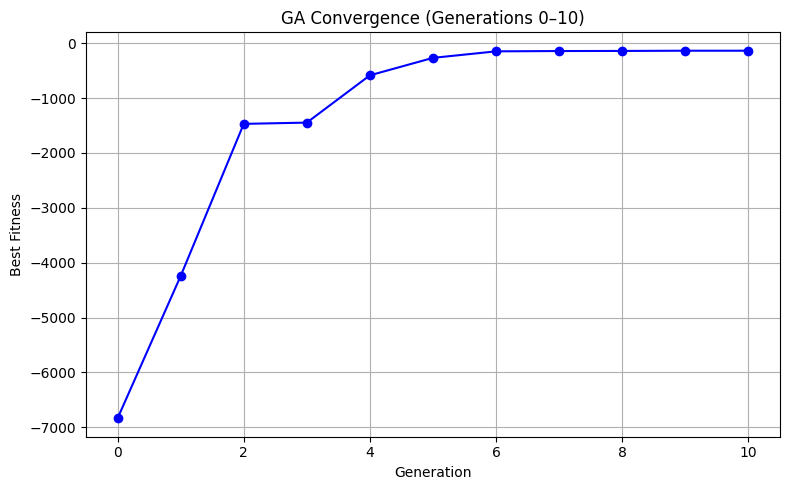

In [26]:
import matplotlib.pyplot as plt

# Plot best fitness from generation 0 to 10
plt.figure(figsize=(8, 5))
plt.plot(best_fitness_over_time[:11], marker='o', linestyle='-', color='blue')
plt.title("GA Convergence (Generations 0–10)")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()


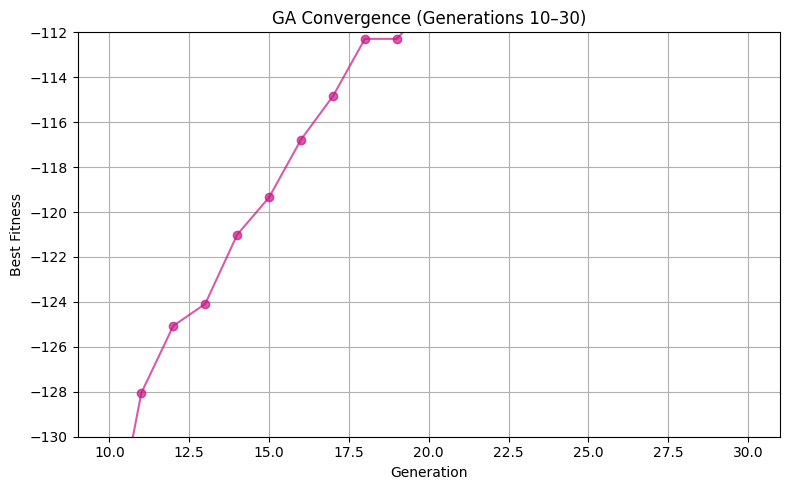

In [27]:
import matplotlib.pyplot as plt

# Slice the generations 10 to 30 (inclusive)
start_gen = 10
end_gen = 30

plt.figure(figsize=(8, 5))
# Corrected the range to include the end generation
plt.plot(range(start_gen, end_gen + 1), best_fitness_over_time[start_gen:end_gen + 1],
         marker='o', linestyle='-', color='mediumvioletred', alpha=0.7)

plt.title("GA Convergence (Generations 10–30)")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.ylim(-130, -112)  # Zoom into desired fitness range
plt.grid(True)
plt.tight_layout()
plt.show()

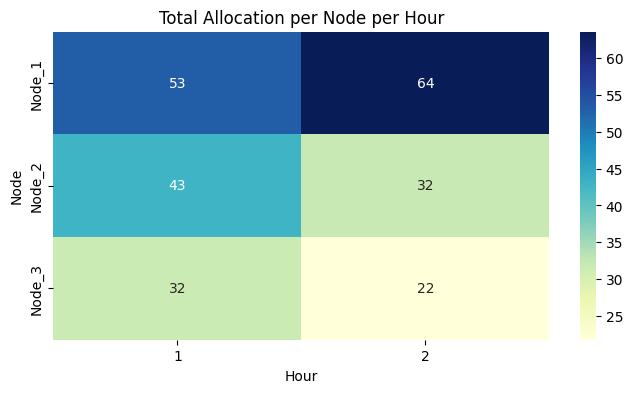

In [28]:
import seaborn as sns

# Reshape the best solution to be 3D
allocation = best_solution.reshape(chromosome_shape)

# Sum over sources for each node/hour
node_hour_alloc = np.sum(allocation, axis=1)

plt.figure(figsize=(8, 4))
sns.heatmap(np.round(node_hour_alloc, 2), annot=True, cmap="YlGnBu", xticklabels=hours, yticklabels=nodes)
plt.title("Total Allocation per Node per Hour")
plt.xlabel("Hour")
plt.ylabel("Node")
plt.show()

In [29]:
# Evaluate best_solution allocations
allocation = best_solution.reshape(len(nodes), len(sources), len(hours))

total_cost = 0
total_loss = 0
total_unmet_demand = 0
total_demand = 0
oversupply_violations = []

supply_used = {(src, hr): 0 for src in sources for hr in hours}

for i, node in enumerate(nodes):
    for h_idx, hr in enumerate(hours):
        node_demand = demand[(node, hr)]
        total_allocated = 0

        for j, src in enumerate(sources):
            alloc = allocation[i, j, h_idx]
            loss = alloc * loss_percentage[src]
            net = alloc - loss

            total_cost += alloc * cost_per_kwh[src]
            total_loss += loss
            total_allocated += net

            supply_used[(src, hr)] += alloc

        total_demand += node_demand
        total_unmet_demand += max(0, node_demand - total_allocated)

# Check supply violations
for key in supply_used:
    if supply_used[key] > supply[key]:
        oversupply_violations.append((key, round(supply_used[key] - supply[key], 2)))

# Summary print
print("\n===== Final Solution Evaluation =====")
print(f"Total Cost:           {total_cost:.2f}")
print(f"Total Line Loss:      {total_loss:.2f}")
print(f"Total Demand:         {total_demand} kWh")
print(f"Unmet Demand:         {total_unmet_demand:.2f} kWh")
print(f"Coverage (%):         {(1 - total_unmet_demand / total_demand) * 100:.2f}%")

if oversupply_violations:
    print(f"Oversupply Violations: {len(oversupply_violations)}")
    for k, amt in oversupply_violations:
        print(f"  - {k}: {amt} kWh over")
else:
    print("No supply capacity violations ")



===== Final Solution Evaluation =====
Total Cost:           30.60
Total Line Loss:      15.28
Total Demand:         230 kWh
Unmet Demand:         0.26 kWh
Coverage (%):         99.89%
No supply capacity violations 


In [30]:
def greedy_chromosome():
    chrom = np.zeros(chromosome_shape)
    for i, node in enumerate(nodes):
        for h_idx, hr in enumerate(hours):
            remaining = demand[(node, hr)]
            for j, src in sorted(enumerate(sources), key=lambda x: cost_per_kwh[x[1]]):
                alloc = min(remaining, supply[(src, hr)])
                chrom[i, j, h_idx] = alloc
                remaining -= alloc
                if remaining <= 0:
                    break
    return chrom


In [31]:
# Redefine the fitness function to reset it
def fitness(chromosome):
    penalty = 0
    total_cost = 0
    total_loss = 0
    allocation = chromosome.reshape(len(nodes), len(sources), len(hours))
    supply_used = {(src, hr): 0 for src in sources for hr in hours}

    for i, node in enumerate(nodes):
        for h_idx, hr in enumerate(hours):
            demand_required = demand[(node, hr)]
            total_allocated = 0
            for j, src in enumerate(sources):
                alloc = allocation[i, j, h_idx]
                loss = alloc * loss_percentage[src]
                net = alloc - loss
                total_allocated += net
                supply_used[(src, hr)] += alloc
                total_cost += alloc * cost_per_kwh[src]
                total_loss += loss
            if total_allocated < demand_required:
                penalty += (demand_required - total_allocated) ** 2
    for key, used in supply_used.items():
        if used > supply[key]:
            penalty += (used - supply[key]) ** 2
    return -(1.0 * total_cost + 5.0 * total_loss + 10.0 * penalty)


In [32]:
from multiprocessing import Pool

def evaluate_population(pop):
    with Pool() as pool:
        return pool.map(fitness, pop)  # this calls your function 'fitness'

# Inside GA loop:
fitness_scores = evaluate_population(population)  #  rename this
gen_best_score = max(fitness_scores)
gen_best_solution = population[np.argmax(fitness_scores)]

if gen_best_score > best_fitness:
    best_fitness = gen_best_score
    best_solution = gen_best_solution


In [33]:
import time

# Serial
start = time.perf_counter()
fitnesses_serial = [fitness(c) for c in population]
end = time.perf_counter()
print(f"Serial evaluation took: {end - start:.4f} seconds")

# Parallel
start = time.perf_counter()
fitnesses_parallel = evaluate_population(population)
end = time.perf_counter()
print(f"Parallel evaluation took: {end - start:.4f} seconds")


Serial evaluation took: 0.0019 seconds
Parallel evaluation took: 0.0459 seconds


In [34]:
import folium
from folium import PolyLine
import numpy as np

# === Sample coordinates for sources and nodes ===
sources = {
    "Solar": [48.85, 2.35],      # Paris
    "Wind": [45.46, 9.19],       # Milan
    "Hydro": [40.42, -3.70],     # Madrid
}

nodes = {
    "Node_1": [51.51, -0.13],    # London
    "Node_2": [50.85, 4.35],     # Brussels
    "Node_3": [52.52, 13.40],    # Berlin
    "Node_4": [48.21, 16.36],    # Vienna
    "Node_5": [41.15, -8.61],    # Porto
    "Node_6": [38.72, -9.14],    # Lisbon
    "Node_7": [43.29, 5.37],     # Marseille
    "Node_8": [47.38, 8.54],     # Zurich
    "Node_9": [46.06, 14.51],    # Ljubljana
    "Node_10": [45.81, 15.98],   # Zagreb
}

# === Optional: Fake example allocations from GA ===
# You should replace this with actual sums from your GA solution
allocations = {
    ("Solar", "Node_1"): 50,
    ("Wind", "Node_1"): 20,
    ("Hydro", "Node_2"): 60,
    ("Solar", "Node_3"): 35,
    ("Wind", "Node_4"): 40,
    ("Hydro", "Node_5"): 55,
    ("Solar", "Node_6"): 30,
    ("Wind", "Node_7"): 25,
    ("Hydro", "Node_8"): 45,
    ("Solar", "Node_9"): 10,
    ("Wind", "Node_10"): 15,
}

# === Create folium map ===
m = folium.Map(location=[48.0, 9.0], zoom_start=5)

# Add source markers
for name, loc in sources.items():
    folium.Marker(loc, popup=name, icon=folium.Icon(color='green')).add_to(m)

# Add demand node markers
for name, loc in nodes.items():
    folium.Marker(loc, popup=name, icon=folium.Icon(color='blue')).add_to(m)

# Add lines from sources to nodes based on allocation
for (src, node), energy in allocations.items():
    line = PolyLine(
        locations=[sources[src], nodes[node]],
        color='skyblue',
        weight=max(2, energy / 10),  # thickness based on allocation
        tooltip=f"{src} → {node}: {energy:.1f} kWh"
    )
    line.add_to(m)

# Optional: Add summary marker
folium.Marker(
    [36, -5],  # position for text box
    icon=folium.DivIcon(html=f"<div style='font-size:14px'><b>Best Fitness: -118.4<br>Generation: 100</b></div>")
).add_to(m)

# Show or save
m.save("smartgrid_node_map.html")
m  # For inline display in notebook


In [35]:
import torch
import numpy as np


In [36]:
def fitness_gpu(pop_tensor, demand_tensor, cost_tensor, loss_tensor, supply_tensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pop = pop_tensor.to(device)
    demand = demand_tensor.to(device)
    cost = cost_tensor.to(device)
    loss = loss_tensor.to(device)
    supply = supply_tensor.to(device)

    net = pop * (1 - loss.view(1, 1, -1, 1))
    total_cost = (pop * cost.view(1, 1, -1, 1)).sum(dim=(1, 2, 3))
    total_net_supply = net.sum(dim=2)

    unmet = torch.clamp(demand - total_net_supply, min=0)
    penalty = unmet.pow(2).sum(dim=(1, 2))

    fitness = -(total_cost + 10 * penalty)
    return fitness.cpu().numpy()


In [46]:
# Assume nodes, sources, hours are defined
demand_tensor = torch.tensor([[demand[(n, h)] for h in hours] for n in nodes], dtype=torch.float32)
cost_tensor = torch.tensor([cost_per_kwh[src] for src in sources], dtype=torch.float32)
loss_tensor = torch.tensor([loss_percentage[src] for src in sources], dtype=torch.float32)
supply_tensor = torch.tensor([[supply[(src, h)] for h in hours] for src in sources], dtype=torch.float32)


In [47]:
use_gpu = torch.cuda.is_available()

# Inside your GA loop
if use_gpu:
    pop_tensor = torch.tensor(np.array(population), dtype=torch.float32)
    fitness_scores = fitness_gpu(pop_tensor, demand_tensor, cost_tensor, loss_tensor, supply_tensor)
else:
    fitness_scores = [fitness(c) for c in population]


🖥️ Running fitness on: cuda


In [48]:
import time

use_gpu = torch.cuda.is_available()

start = time.perf_counter()
# run fitness_scores as above
end = time.perf_counter()
print(f" Fitness Eval Time ({'GPU' if use_gpu else 'CPU'}): {end - start:.4f} s")

 Fitness Eval Time (GPU): 0.0000 s


In [49]:
import time
from random import uniform

# Redefine the nodes, sources, and hours to match the chromosome shape
nodes = ['Node_1', 'Node_2', 'Node_3']
sources = ['Solar', 'Wind']
hours = [1, 2]

# Generate bigger population with the correct chromosome shape
population = [np.random.uniform(low=0, high=30, size=(3, 2, 2)) for _ in range(1000)]

start = time.perf_counter()
fitness_scores = [fitness(c) for c in population]
end = time.perf_counter()
print(f"CPU Fitness Eval Time: {end - start:.4f} s")

CPU Fitness Eval Time: 0.0147 s


In [50]:
def fitness_gpu(pop_tensor, demand_tensor, cost_tensor, loss_tensor, supply_tensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🖥️ Running fitness on: {device}")

    pop = pop_tensor.to(device)
    demand = demand_tensor.to(device)
    cost = cost_tensor.to(device)
    loss = loss_tensor.to(device)
    supply = supply_tensor.to(device)

    net = pop * (1 - loss.view(1, 1, -1, 1))
    total_cost = (pop * cost.view(1, 1, -1, 1)).sum(dim=(1, 2, 3))
    total_net_supply = net.sum(dim=2)

    unmet = torch.clamp(demand - total_net_supply, min=0)
    penalty = unmet.pow(2).sum(dim=(1, 2))

    fitness = -(total_cost + 10 * penalty)
    return fitness.cpu().numpy()

In [51]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device() if torch.cuda.is_available() else "None")
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")


GPU Available: True
Device Count: 1
Current Device: 0
Device Name: Tesla T4
